## Generate gridded plot from the NetCDF file created by generateGriddedAODProducts notebook
This notebook read the gridded output in and create horizontal distribution plots of mean and standard deviation for obs, H(x), and obs - H(x).
The variables to be processed are in the format: `{obsname}_{obs|hofx|omb}_{count|mean|std}`

In [1]:
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mpcrs
from functions import setup_cmap

### Setup features of figure

In [2]:
tlsize = 12
txsize = 12
mpl.rc('axes', titlesize=tlsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='small')
minussign = u'\u2212'

plts_savedir = '/glade/work/swei/projects/mmm.pace_aod/plots/gridded'
infile = '/glade/work/swei/projects/mmm.pace_aod/aod_obs_stats.m2.202411.nc4'
if not os.path.exists(plts_savedir):
    os.makedirs(plts_savedir)
axe_w = 6.4
axe_h = 4
quality = 600

base = 'pace_aod'
plotting_list = [
    'omb_mean',
    # 'obs_count', 
    # 'obs_mean', 'obs_std',
    # 'hofx_mean', 'hofx_std',
    # 'omb_mean', 'omb_std',
]
plot_stats_dict = {
    'obs_count': {'vmin': 0, 'vmax': 2000, 'cmap': 'hot_r', 'diffRatio': 1.},
    'obs_mean': {'vmin': 0., 'vmax': 2., 'cmap': None, 'diffRatio': 4.},
    'hofx_mean': {'vmin': 0., 'vmax': 2., 'cmap': None, 'diffRatio': 4.},
    'omb_mean': {'vmin': -0.5, 'vmax': 0.5, 'cmap': 'Spectral_r', 'diffRatio': 4.},
    'obs_std': {'vmin': 0., 'vmax': 2., 'cmap': 'hot_r', 'diffRatio': 2.},
    'hofx_std': {'vmin': 0., 'vmax': 2., 'cmap': 'hot_r', 'diffRatio': 2.},
    'omb_std': {'vmin': 0., 'vmax': 0.5, 'cmap': 'hot_r', 'diffRatio': 2.},
}

data_name_dict = {
    'pace_aod': 'OCI UAA AOD on PACE',
    'modis_aqua_aod': 'MODIS AOD on Aqua',
    'modis_terra_aod': 'MODIS AOD on Terra',
    'viirs_aod_dt_n20': 'VIIRS DT AOD on NOAA-20',
    'viirs_aod_db_n20': 'VIIRS DB AOD on NOAA-20',
    'viirs_aod_dt_npp': 'VIIRS DT AOD on Suomi-NPP',
    'viirs_aod_db_npp': 'VIIRS DB AOD on Suomi-NPP',
}

### Define local functions

In [3]:
def get_process_dataset(dataset, vartype):
    outlist = []
    inlist = list(ds.data_vars)
    for tmp in inlist:
        if vartype in tmp:
            outlist.append(tmp)
    outds = ds[outlist]
    return outds, outlist


def plot_full(pltds, plot_dict, title, plot_outname):
    if plot_dict['cmap'] is None:
        cnlvs = [0., 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5, 2.5]
        clridx = [2, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18]
        tuplelst, clrmap = setup_cmap('precip3_16lev', cnlvs, clridx)
        clr_norm = mpcrs.BoundaryNorm(cnlvs, len(clridx), extend='both')
        p = pltds.plot(
            levels=cnlvs,
            size=4,
            aspect=1.6,
            subplot_kws=dict(
                projection=ccrs.PlateCarree()
            ),
            cmap=clrmap,
            norm=clr_norm,
            extend='both',
            add_colorbar=True,
            cbar_kwargs=dict(
                label=None,
                pad=0.05,
                fraction=0.025,
                ticks=cnlvs,
            ),
        )
    else:
        p = pltds.plot(
            vmin=plot_dict['vmin'],
            vmax=plot_dict['vmax'],
            extend='both',
            size=4,
            aspect=1.6,
            subplot_kws=dict(
                projection=ccrs.PlateCarree()
            ),
            cmap= plot_dict['cmap'],
            add_colorbar=True,
            cbar_kwargs=dict(
                label=None,
                pad=0.05,
                fraction=0.025,
            ),
        )
    # p.axes.gridlines(draw_labels=False)
    p.axes.coastlines(color='grey')
    p.axes.set_title(title)
    p.axes.text(
        0.5, -0.03,
        f"Min= {pltds.min():.2f}, Max= {pltds.max():.2f}",
        ha="center", va="top", transform=p.axes.transAxes
    )
    p.figure.savefig(plot_outname, dpi=quality)


def plot_diff(pltds, plot_dict, title, plot_outname):
    vmin = -plot_dict['vmax'] / plot_dict['diffRatio']
    vmax = plot_dict['vmax'] / plot_dict['diffRatio']
    p = pltds.plot(
        # center=0.,
        extend='both',
        vmin=vmin,
        vmax=vmax,
        size=4,
        aspect=1.6,
        subplot_kws=dict(
            projection=ccrs.PlateCarree()
        ),
        cmap='Spectral_r',
        add_colorbar=True,
        cbar_kwargs=dict(
            label=None,
            pad=0.05,
            fraction=0.025,
        ),
    )
    # p.axes.gridlines(draw_labels=False)
    p.axes.coastlines(color='grey')
    p.axes.set_title(title)
    p.axes.text(
        0.5, -0.03,
        f"Min= {pltds.min():.2f}, Max= {pltds.max():.2f}",
        ha="center", va="top", transform=p.axes.transAxes
    )
    p.figure.savefig(plot_outname, dpi=quality)


### Load gridded NetCDF files

In [4]:
ds = xr.open_dataset(infile)

### Loop through plotting list and create plots of full field and difference with respect to the base observation

Prorcessing modis_terra_aod_omb_mean
Prorcessing modis_aqua_aod_omb_mean
Prorcessing pace_aod_omb_mean
Prorcessing viirs_aod_dt_npp_omb_mean
Prorcessing viirs_aod_dt_n20_omb_mean
Prorcessing viirs_aod_db_npp_omb_mean
Prorcessing viirs_aod_db_n20_omb_mean
Process Finished


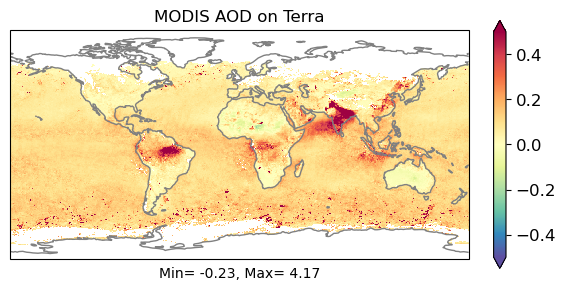

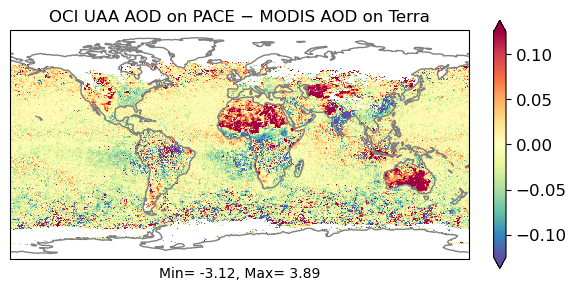

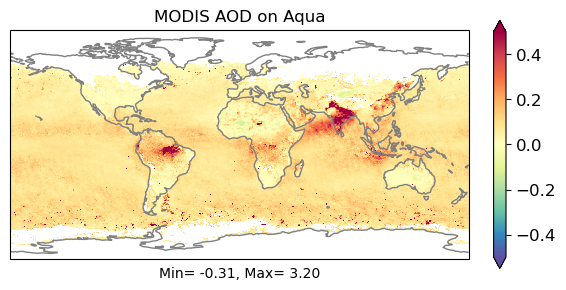

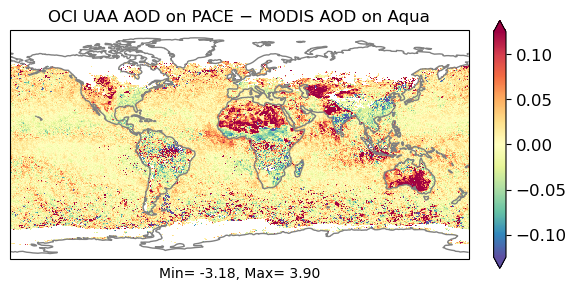

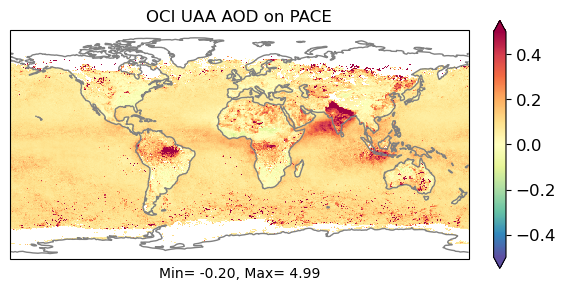

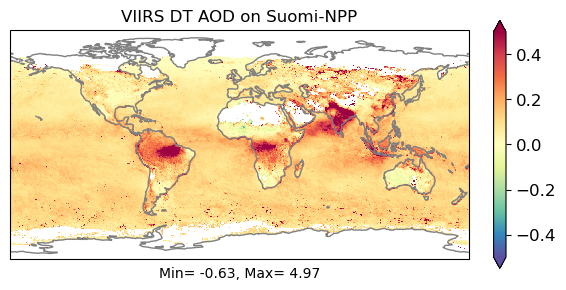

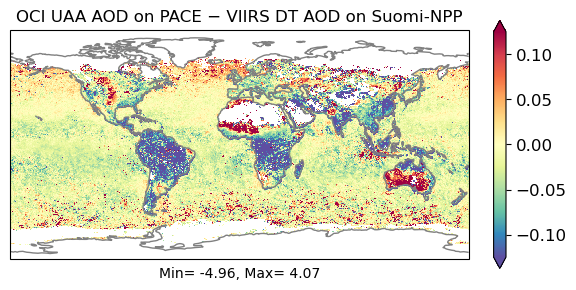

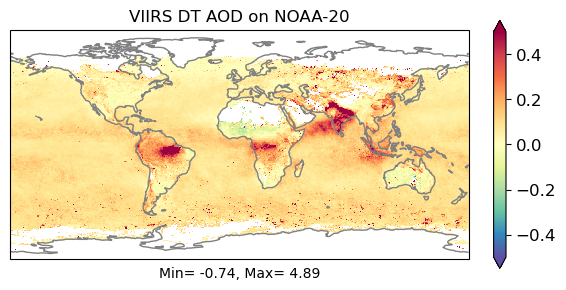

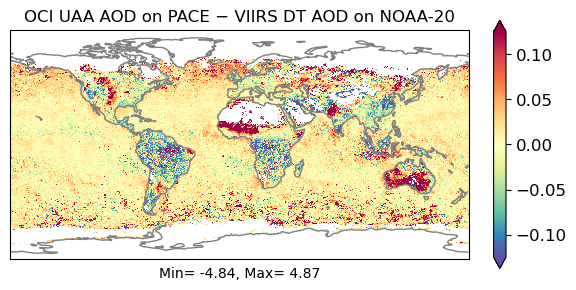

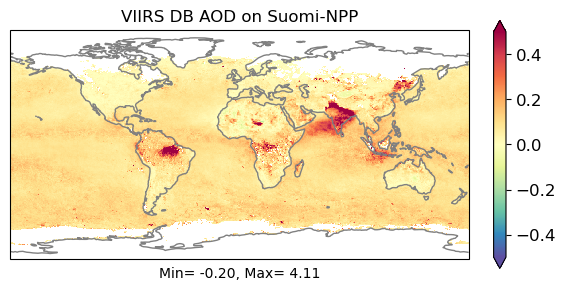

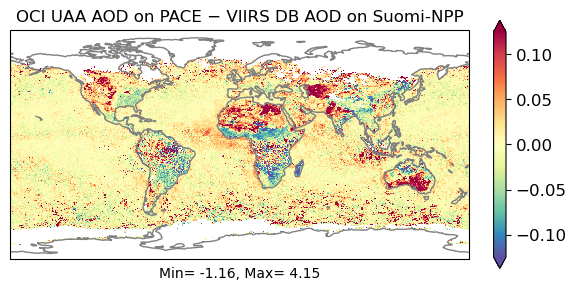

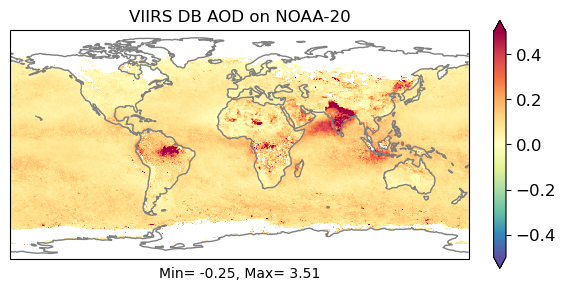

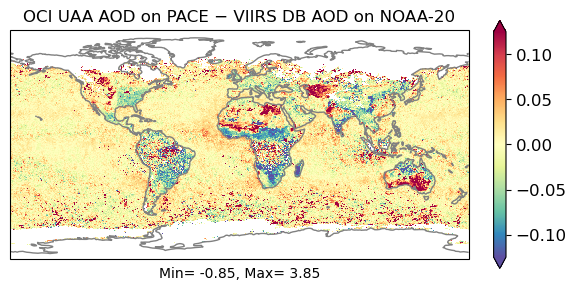

In [5]:
for varType in plotting_list:
    baseVar = f'{base}_{varType}'
    process_ds, process_list = get_process_dataset(ds, varType)
    plot_dict = plot_stats_dict[varType]
    if 'count' in varType:
        wrkds = process_ds.sum(dim='time')
    else:
        wrkds = process_ds.mean(dim='time')

    for plotVar in process_list:
        data = plotVar.replace("_"+varType, "")
        print(f'Prorcessing {plotVar}')
        plot_outname = f'{plts_savedir}/{varType}.{data}.202411.png'
        title = f'{data_name_dict[plotVar.replace("_"+varType, "")]}'
        plot_full(wrkds[plotVar], plot_dict, title, plot_outname)
        if plotVar != baseVar:
            plot_outname = f'{plts_savedir}/{varType}.{base}-{data}.202411.png'
            title = f'{data_name_dict[base]} {minussign} {data_name_dict[plotVar.replace("_"+varType, "")]}'
            plot_diff(wrkds[baseVar] - wrkds[plotVar], plot_dict, title, plot_outname)
print("Process Finished")